# Random Sample

## 1. Exponential Distribution

1.  **自行實作** 指數分布的隨機數產生器（要能自訂發生的速率 λ ），**禁止使用 NumPy、SciPy 或其他模組內建的指數/泊松分布抽樣函數**。
2.  產生 1000 個指數分布的隨機數，並計算它們的**均值（mean）與變異數（variance）**，檢查是否接近理論值。
3.  **畫出直方圖**，觀察數據是否符合指數分布的形狀。
4.  提示：可以用 Inverse Transform Sampling。


## 2. 驗證 Exponential Distribution 與 Poisson Distribution 的關係

### 背景知識

Poisson Distribution 描述的是**固定時間內發生的事件數量**。而指數分布描述的是**事件之間的時間間隔**，如果事件是根據 Poisson Distribution 發生的，那麼**事件發生的間隔時間**服從 Exponential Distribution。換句話說，泊松分布與指數分布存在以下關係：

-   如果事件發生的時間間隔服從**指數分布**，那麼在單位時間內發生的事件數量就會服從**泊松分布**。
-   也就是說，如果我們產生很多**指數分布的隨機數**，並將它們累積起來，統計某段時間內發生的事件數量，那麼這些數據應該會符合泊松分布。

### 實驗設計

請按照以下步驟進行實驗，並驗證泊松分布與指數分布的關係：

1.  **使用內建函數（NumPy 或 SciPy）產生泊松分布與指數分布的隨機數：**
    -   產生 1000 個泊松分布的隨機數（使用 `numpy.random.poisson(λ, size)`）。
    -   產生 1000 個指數分布的隨機數（使用 `numpy.random.exponential(1/λ, size)`）。
2.  **驗證指數分布的間隔時間能夠模擬泊松分布：**
    -   產生 10000 個指數分布的隨機數，將這些數字看成是事件發生的間隔時間。
    -   透過累積間隔時間，計算在單位時間內發生的事件數，這些數據應該符合泊松分布。
    -   計算這些數據的均值與變異數，與泊松分布的理論值 E[X]=λ，Var(X)=λ 比較。
3.  **畫出直方圖，觀察分布形狀：**
    -   繪製泊松分布與指數分布的直方圖，檢查它們的形狀是否符合理論分布。
    -   繪製指數分布累積後得到的泊松分布直方圖，檢查其是否與內建的泊松分布相似。


# 模擬結果

[程式連結](https://github.com/AsherJingkongChen/random-sample/blob/main/random_sample.ipynb)


+-----------------------------------------+------+------+------------------+
|                                 subject | size | rate | [mean, variance] |
+==========================================================================+
| (theoretical) random_sample_exponential |    0 |    1 | [1.0000, 1.0000] |
| (theoretical) random_sample_exponential |    0 |    2 | [0.5000, 0.2500] |
| (theoretical) random_sample_exponential |    0 |    3 | [0.3333, 0.1111] |
|               random_sample_exponential | 1000 |    1 | [1.0123, 1.0005] |
|               random_sample_exponential | 1000 |    2 | [0.5062, 0.2501] |
|               random_sample_exponential | 1000 |    3 | [0.3374, 0.1112] |
+-----------------------------------------+------+------+------------------+


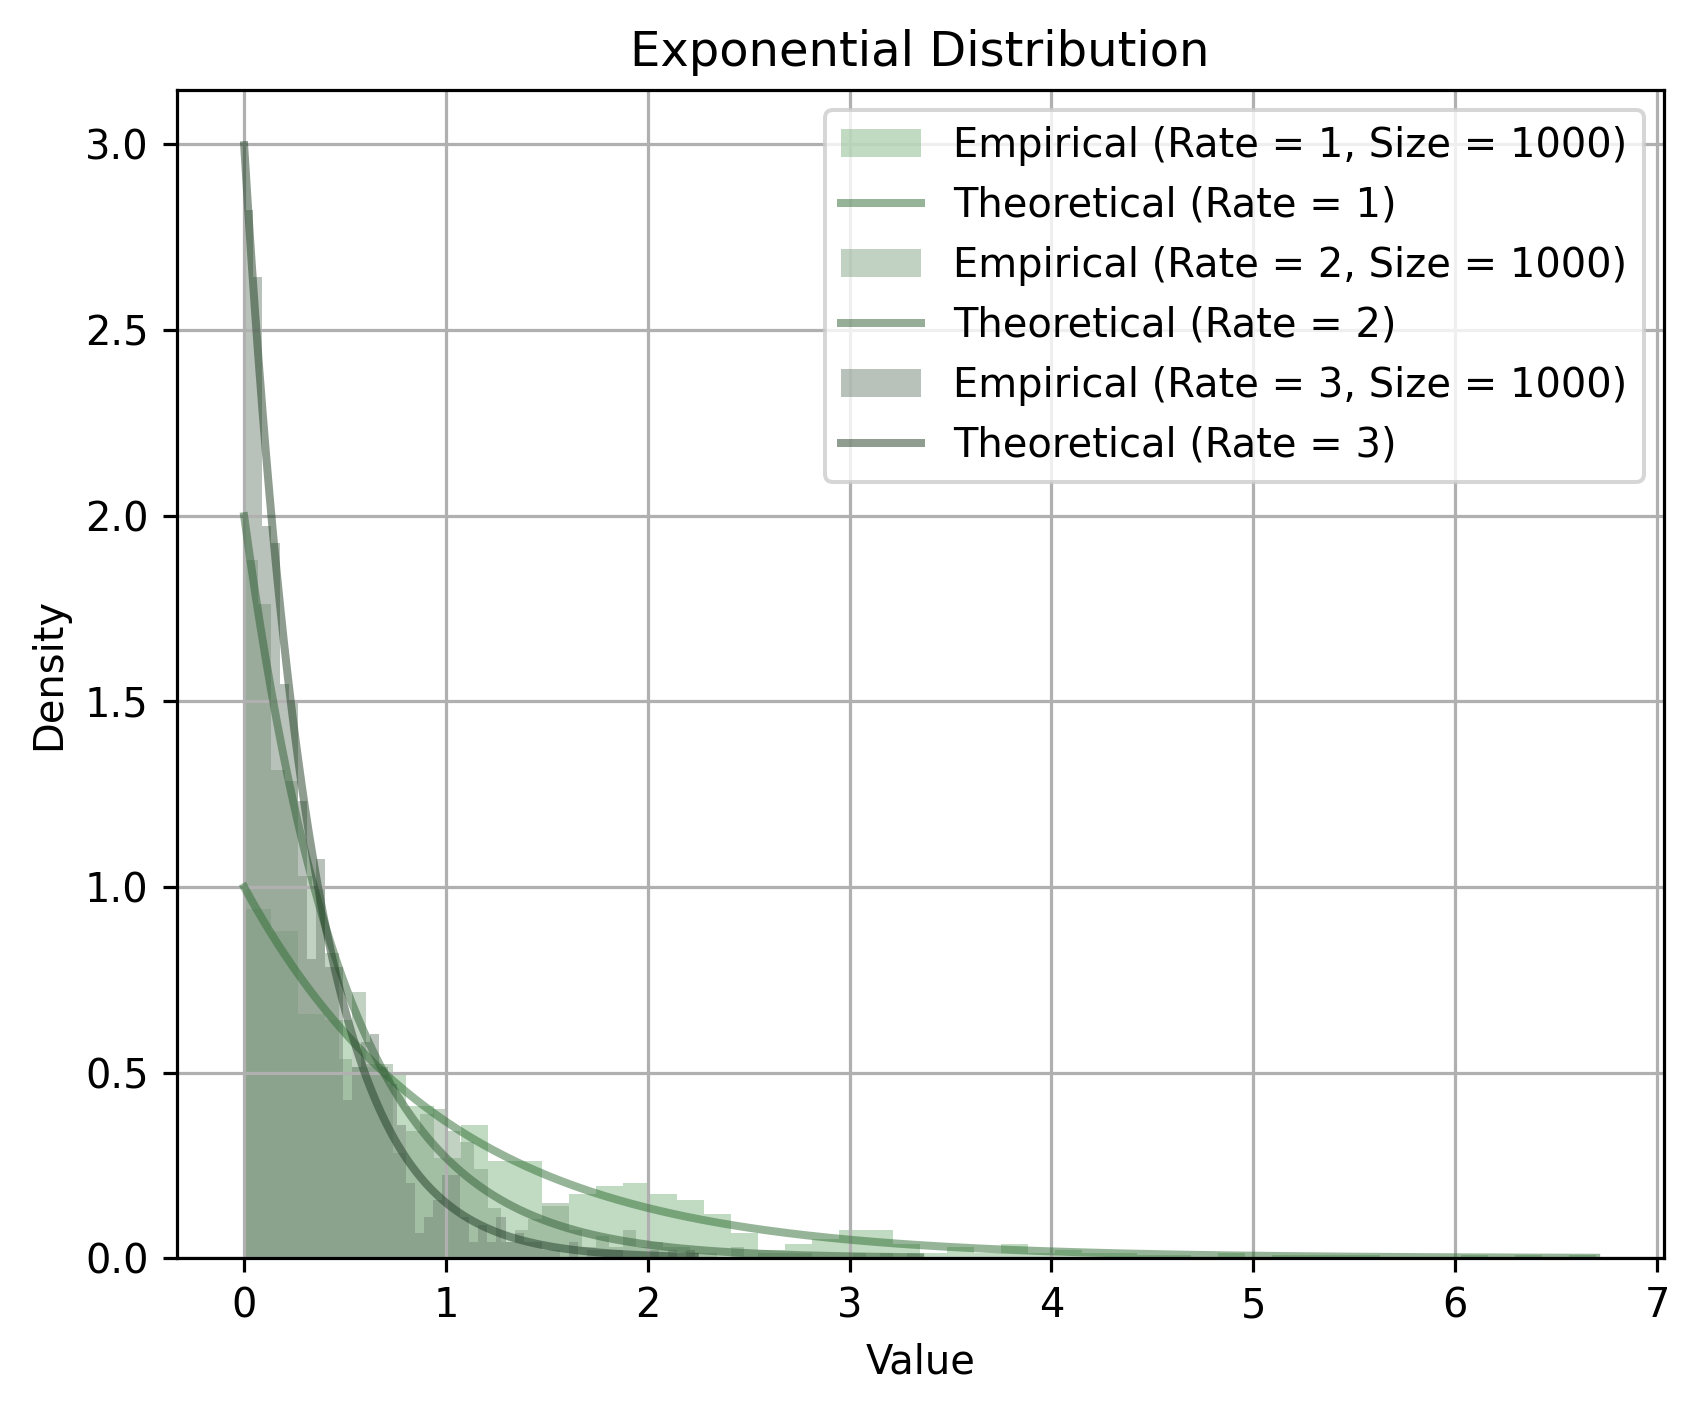

In [18]:
import numpy as np
import polars as pl

from cycler import cycler
from matplotlib import pyplot as plt
from numpy.typing import ArrayLike
from typing import Callable, Optional, Tuple


def build_stats(seq: ArrayLike) -> tuple[float, float]:
    return np.mean(seq), np.var(seq)


def random_sample_exponential(size: int, rate: int, seed: int) -> ArrayLike:
    uniform_samples = np.random.default_rng(seed).uniform(size=size)
    return -np.log(uniform_samples) / rate


def random_sample_exponential_p(x: ArrayLike, rate: int) -> ArrayLike:
    return rate * np.exp(-rate * np.maximum(x, 0))


def draw_sample_histogram(
    *,
    axis: plt.Axes,
    empirical_data: ArrayLike,
    empirical_label: str = "Empirical",
    theoretical_data: Optional[Callable[[ArrayLike], ArrayLike]] = None,
    theoretical_label: str = "Theoretical",
) -> Tuple[plt.Figure, plt.Axes]:
    bins = axis.hist(
        empirical_data,
        alpha=0.5,
        bins=50,
        density=True,
        label=empirical_label,
    )[1]
    if theoretical_data is not None:
        theoretical_line_x = np.linspace(bins[0], bins[-1], 500)
        axis.plot(
            theoretical_line_x,
            theoretical_data(theoretical_line_x),
            alpha=0.5,
            label=theoretical_label,
            lw=2,
        )

    axis.set_title("Sample Histogram")
    axis.set_xlabel("Value")
    axis.set_ylabel("Density")
    axis.legend()
    axis.grid(True)
    return axis.figure, axis


if __name__ == "__main__":
    RATE_TEST_VALUES = [1, 2, 3]
    SEED = 42
    TABLE_WIDTH_MAX = 120

    with pl.Config(
        ascii_tables=True,
        float_precision=4,
        fmt_str_lengths=TABLE_WIDTH_MAX,
        tbl_cell_alignment="RIGHT",
        tbl_cols=TABLE_WIDTH_MAX,
        tbl_hide_column_data_types=True,
        tbl_hide_dataframe_shape=True,
        tbl_width_chars=TABLE_WIDTH_MAX,
    ):
        print(
            pl.concat(
                [
                    pl.DataFrame(
                        {
                            "subject": "(theoretical) random_sample_exponential",
                            "size": 0,
                            "rate": RATE_TEST_VALUES,
                            "[mean, variance]": [
                                [1 / 1, 1 / 1**2],
                                [1 / 2, 1 / 2**2],
                                [1 / 3, 1 / 3**2],
                            ],
                        }
                    ),
                    pl.DataFrame(
                        dict(
                            subject="random_sample_exponential",
                            size=1000,
                            rate=RATE_TEST_VALUES,
                        )
                    ).with_columns(
                        pl.struct(["size", "rate"])
                        .map_elements(
                            lambda r: build_stats(
                                random_sample_exponential(
                                    size=r["size"],
                                    rate=r["rate"],
                                    seed=SEED,
                                )
                            ),
                            return_dtype=pl.List(pl.Float64),
                        )
                        .alias("[mean, variance]"),
                    ),
                ]
            )
        )

    with plt.rc_context(
        {
            "axes.prop_cycle": cycler(
                color=[
                    "#85B687",
                    "#2E6D32",
                    "#85A687",
                    "#2E5D32",
                    "#758677",
                    "#1E3D22",
                ],
            ),
        }
    ):
        SAMPLE_SIZE = 1000
        axes = plt.subplots(dpi=288, figsize=(6, 5))[1]

        for rate in RATE_TEST_VALUES:
            axis = axes
            draw_sample_histogram(
                axis=axis,
                empirical_data=random_sample_exponential(
                    size=SAMPLE_SIZE,
                    rate=rate,
                    seed=SEED,
                ),
                empirical_label=f"Empirical (Rate = {rate}, Size = {SAMPLE_SIZE})",
                theoretical_label=f"Theoretical (Rate = {rate})",
                theoretical_data=lambda x: random_sample_exponential_p(x, rate),
            )

        plt.title("Exponential Distribution")
        plt.tight_layout()
        plt.show()

## 結論

-   **第 1 題**：採樣的隨機數符合指數分佈，均值與變異數接近理論值。
    -   例如當速率 $\lambda = 2$ 時，採樣 $1000$ 個隨機數的平均數約為 $0.5062$，與理論值 $0.5$ 的相對誤差約為 $0.0124$（符合理論）；變異數約為 $0.2501$，與理論值 $0.25$ 的相對誤差約為 $0.0004$（符合理論）。經驗分佈函式 $\text{Empirical (Rate = 2, Size = 1000)}$ 也符合機率密度函式 $\text{Theoretical (Rate = 2)}$ 的形狀。
-   **第 2 題**：


In [19]:
%%html
<style>
    .jp-Cell.jp-Notebook-cell:nth-last-child(3) .jp-Cell-inputArea,
    .jp-Cell.jp-Notebook-cell:last-child {
        display: none;
    }

    @page {
        size: A4 portrait;
        margin: 5mm 0 !important;
    }

    :root {
        --jp-content-link-color: dodgerblue;
    }

    a code {
        color: var(--jp-content-link-color) !important;
    }

    body {
        margin: 0 !important;
    }

    code,
    pre {
        font-family: Monaco, monospace !important;
        font-size: 10px !important;
        font-weight: 400 !important;
        line-height: 1.25 !important;
    }

    img {
        max-width: 80% !important;
    }

    h1 {
        text-align: center !important;
    }

    h1,
    h2,
    h3,
    h4,
    h5,
    h6,
    strong {
        font-weight: 700 !important;
    }

    h1,
    hr {
        page-break-before: always;
    }

    hr {
        visibility: hidden;
    }

    pre {
        white-space: pre-wrap;
    }

    table,
    td,
    th,
    tr,
    tbody,
    thead,
    tfoot {
        page-break-inside: avoid !important;
    }

    .jp-RenderedHTMLCommon {
        font-family: Calibri, Verdana, sans-serif !important;
        font-size: 12px !important;
        font-weight: 400 !important;
        line-height: 1.25 !important;
    }

    .jp-RenderedHTMLCommon td,
    .jp-RenderedHTMLCommon th,
    .jp-RenderedHTMLCommon tr {
        border: 1px solid var(--md-grey-500);
    }

    .jp-RenderedHTMLCommon table {
        margin-left: 2em;
    }

    .jp-CodeCell {
        margin-bottom: 1.5em;
    }
</style>